In [15]:
import numpy as np
import pandas as pd
import dask as dd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [41]:
data = pd.read_csv('data/heart_attack_dataset.csv')


In [42]:
data.isna().sum()

Age                      0
Gender                   0
Cholesterol              0
BloodPressure            0
HeartRate                0
BMI                      0
Smoker                   0
Diabetes                 0
Hypertension             0
FamilyHistory            0
PhysicalActivity         0
AlcoholConsumption       0
Diet                     0
StressLevel              0
Ethnicity                0
Income                   0
EducationLevel           0
Medication               0
ChestPainType            0
ECGResults               0
MaxHeartRate             0
ST_Depression            0
ExerciseInducedAngina    0
Slope                    0
NumberOfMajorVessels     0
Thalassemia              0
PreviousHeartAttack      0
StrokeHistory            0
Residence                0
EmploymentStatus         0
MaritalStatus            0
Outcome                  0
dtype: int64

In [43]:
data.dtypes

Age                        int64
Gender                    object
Cholesterol                int64
BloodPressure              int64
HeartRate                  int64
BMI                      float64
Smoker                     int64
Diabetes                   int64
Hypertension               int64
FamilyHistory              int64
PhysicalActivity           int64
AlcoholConsumption         int64
Diet                      object
StressLevel                int64
Ethnicity                 object
Income                     int64
EducationLevel            object
Medication                object
ChestPainType             object
ECGResults                object
MaxHeartRate               int64
ST_Depression            float64
ExerciseInducedAngina     object
Slope                     object
NumberOfMajorVessels       int64
Thalassemia               object
PreviousHeartAttack        int64
StrokeHistory              int64
Residence                 object
EmploymentStatus          object
MaritalSta

In [44]:
categories = data.select_dtypes(include=['object'])
categories

,Gender,Diet,Ethnicity,EducationLevel,Medication,ChestPainType,ECGResults,ExerciseInducedAngina,Slope,Thalassemia,Residence,EmploymentStatus,MaritalStatus,Outcome
0,Male,Unhealthy,Hispanic,High School,Yes,Typical,ST-T abnormality,Yes,Downsloping,Normal,Suburban,Retired,Single,No Heart Attack
1,Male,Unhealthy,Asian,College,No,Atypical,LV hypertrophy,Yes,Upsloping,Normal,Suburban,Unemployed,Married,No Heart Attack
2,Female,Healthy,Black,College,No,Non-anginal,Normal,Yes,Upsloping,Normal,Rural,Retired,Single,Heart Attack
3,Male,Healthy,Hispanic,High School,Yes,Atypical,ST-T abnormality,Yes,Flat,Reversible defect,Suburban,Retired,Widowed,No Heart Attack
4,Female,Moderate,Hispanic,High School,Yes,Typical,ST-T abnormality,Yes,Flat,Fixed defect,Rural,Retired,Married,Heart Attack
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372969,Female,Unhealthy,Hispanic,Postgraduate,No,Non-anginal,Normal,Yes,Flat,Fixed defect,Urban,Employed,Married,No Heart Attack
372970,Male,Unhealthy,White,Postgraduate,No,Asymptomatic,LV hypertrophy,No,Downsloping,Fixed defect,Urban,Employed,Married,Heart Attack
372971,Female,Moderate,Other,Postgraduate,No,Asymptomatic,ST-T abnormality,Yes,Flat,Reversible defect,Urban,Retired,Married,Heart Attack
372972,Female,Healthy,Black,High School,No,Atypical,LV hypertrophy,Yes,Upsloping,Fixed defect,Urban,Employed,Married,No Heart Attack


In [45]:
categories.nunique()

Gender                   2
Diet                     3
Ethnicity                5
EducationLevel           3
Medication               2
ChestPainType            4
ECGResults               3
ExerciseInducedAngina    2
Slope                    3
Thalassemia              3
Residence                3
EmploymentStatus         3
MaritalStatus            4
Outcome                  2
dtype: int64

In [46]:
data['heart_rate_ratio'] = data['HeartRate'] / data['MaxHeartRate']
data['heart_rate_deficit'] = data['MaxHeartRate'] - data['HeartRate']
data['cholesterol_age_ratio'] = data['Cholesterol'] / data['Age']
data['blood_pressure_age_ratio'] = data['BloodPressure'] / data['Age']
data['bmi_age_ratio'] = data['BMI'] / data['Age']
data['stress_activity_ratio'] = data['StressLevel'] / (data['PhysicalActivity'] + 1e-5)

data['log_income'] = np.log1p(data['Income']) #not really sure if this will do anything, might test with/without and both

risk_features = ['Smoker', 'Diabetes', 'Hypertension', 'FamilyHistory', 
                 'PreviousHeartAttack', 'StrokeHistory']
data['risk_factor_count'] = data[risk_features].sum(axis=1)

data['age_cholesterol_interaction'] = data['Age'] * data['Cholesterol']
data['age_blood_pressure_interaction'] = data['Age'] * data['BloodPressure']

data.head()

,Age,Gender,Cholesterol,BloodPressure,HeartRate,BMI,Smoker,Diabetes,Hypertension,FamilyHistory,...,heart_rate_ratio,heart_rate_deficit,cholesterol_age_ratio,blood_pressure_age_ratio,bmi_age_ratio,stress_activity_ratio,log_income,risk_factor_count,age_cholesterol_interaction,age_blood_pressure_interaction
0,31,Male,194,162,71,22.9,0,1,0,0,...,0.410405,102,6.258065,5.225806,0.738710,0.166666,11.074591,1,6014,5022
1,69,Male,208,148,93,33.9,1,1,0,0,...,0.492063,96,3.014493,2.144928,0.491304,5.999940,11.427084,2,14352,10212
2,34,Female,132,161,94,34.0,0,0,1,1,...,0.770492,28,3.882353,4.735294,1.000000,2.999970,12.064227,3,4488,5474
3,53,Male,268,134,91,35.0,0,1,1,0,...,0.875000,13,5.056604,2.528302,0.660377,0.499999,10.688804,3,14204,7102
4,57,Female,203,140,75,30.1,0,1,0,0,...,0.595238,51,3.561404,2.456140,0.528070,0.249999,11.331464,2,11571,7980


c:\Users\angel\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


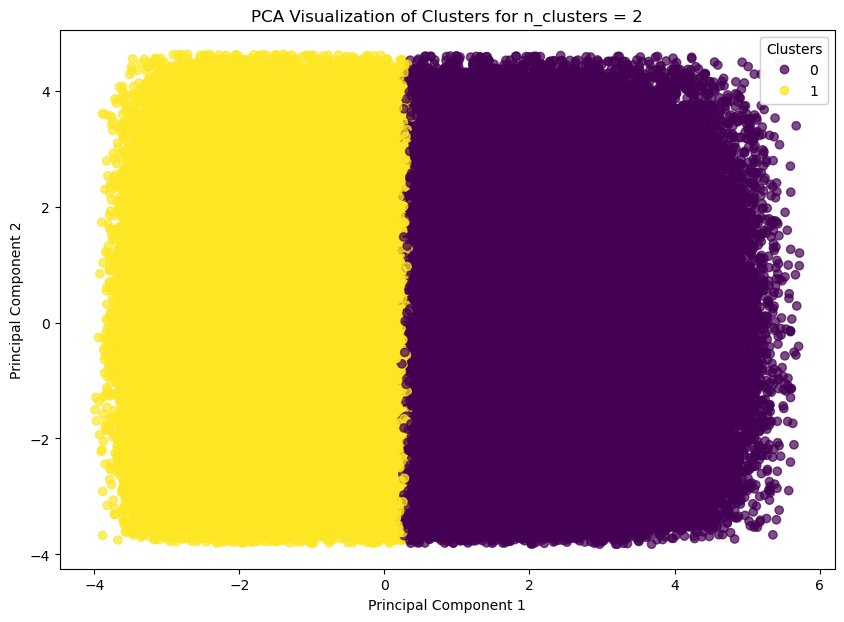

c:\Users\angel\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


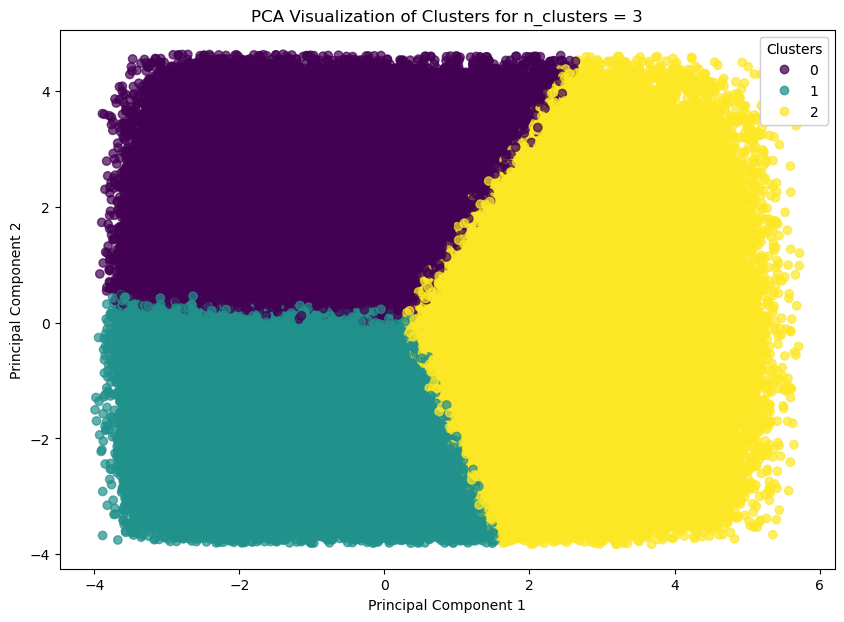

c:\Users\angel\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


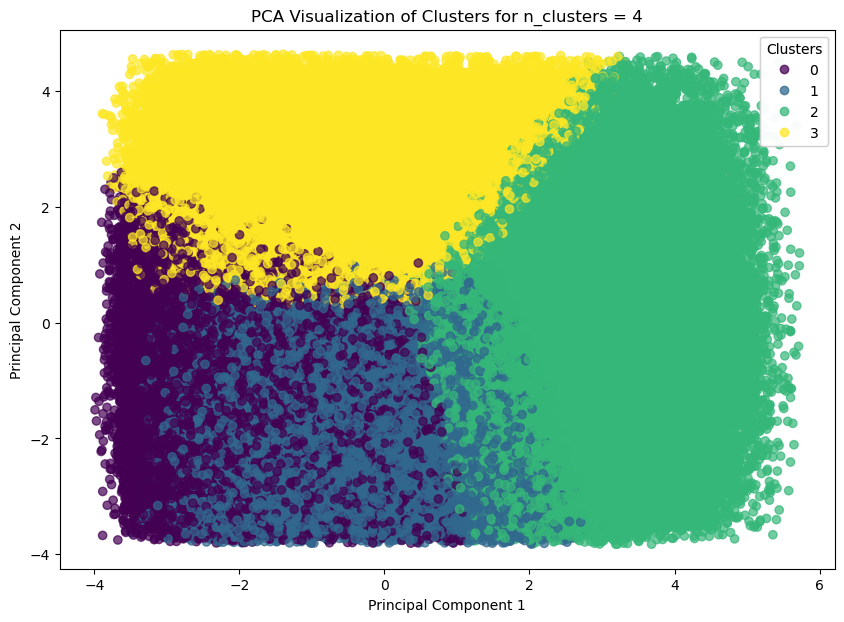

c:\Users\angel\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


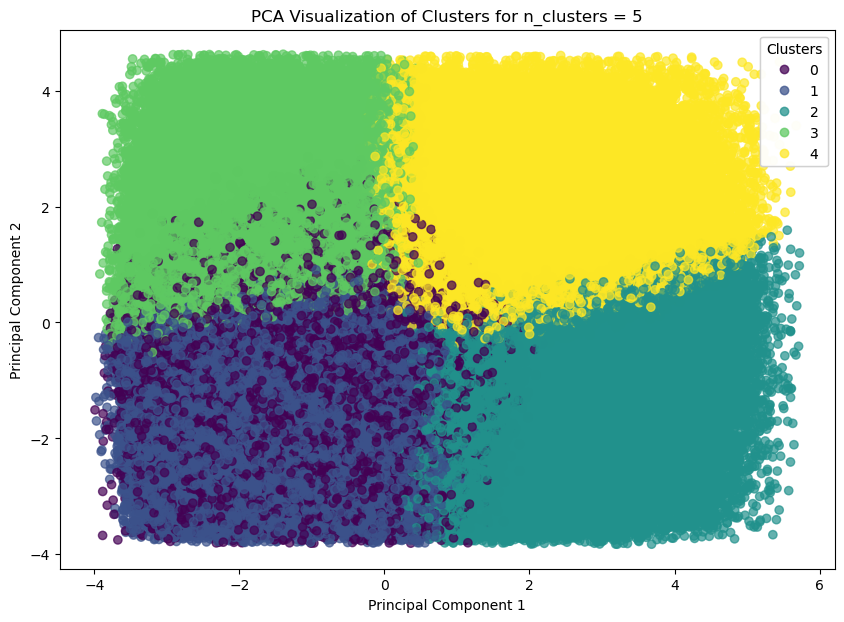

c:\Users\angel\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


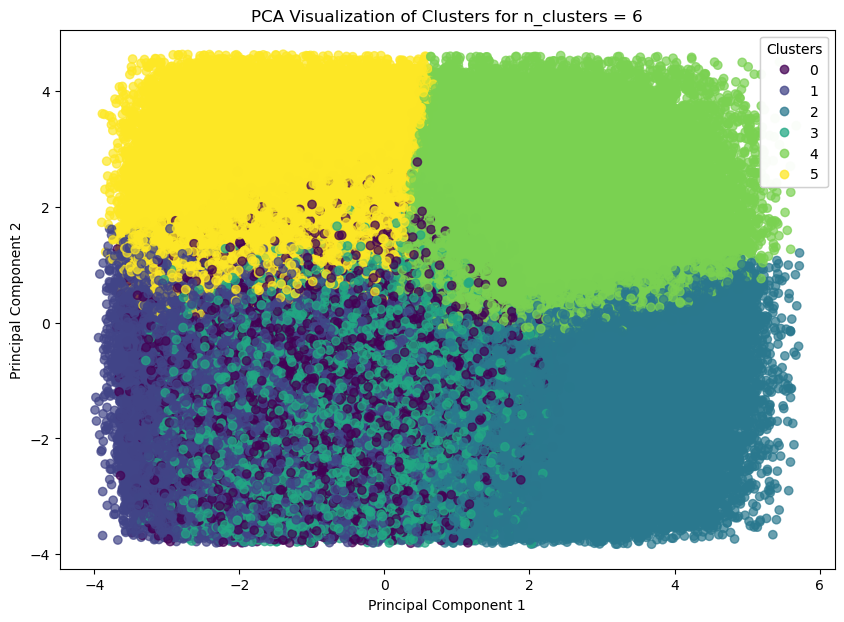

In [50]:

def cluster_and_plot(data, cluster_list, outcome_col='Outcome'):
    """#chat made this for me
    For each n_clusters in cluster_list, this function:
      - Drops the outcome column from data to create features.
      - Builds a pipeline with a preprocessor (scaling numerical and one-hot encoding categorical features)
        and KMeans clustering with n_clusters.
      - Attaches the resulting cluster labels to a new dataframe (a copy of the original data).
      - Plots a PCA visualization of the clustering results.
      
    Parameters:
      data         : Original DataFrame (including the outcome column).
      cluster_list : List of integers specifying the number of clusters to try (e.g., [2,3,4,5,6]).
      outcome_col  : Name of the target column to drop for clustering (default 'Outcome').
      
    Returns:
      A dictionary where keys are n_clusters values and values are the new dataframes with a 'cluster' column.
    """
    features = data.drop(columns=[outcome_col])
    
    num_features = features.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_features = features.select_dtypes(include=['object']).columns.tolist()
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), num_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
        ]
    )
    
    result_dfs = {}
    
    for n in cluster_list:
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('kmeans', KMeans(n_clusters=n, random_state=42))
        ])
        
        pipeline.fit(features)
        
        new_df = data.copy()
        new_df['cluster'] = pipeline.predict(features)
        result_dfs[n] = new_df


        #chat did the plotting
        features_no_cluster = features.copy()
        X_transformed = pipeline.named_steps['preprocessor'].transform(features_no_cluster)
        if hasattr(X_transformed, "toarray"):
            X_transformed = X_transformed.toarray()
        
        # Reduce dimensions to 2 using PCA.
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_transformed)
        
        # Create a scatter plot of the clusters.
        plt.figure(figsize=(10, 7))
        scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=new_df['cluster'], cmap='viridis', alpha=0.7)
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.title(f'PCA Visualization of Clusters for n_clusters = {n}')
        legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
        plt.gca().add_artist(legend1)
        plt.show()
        
    return result_dfs

# --- Example Usage ---
# Assuming you have a DataFrame called 'data' that includes the 'Outcome' column.
cluster_dfs = cluster_and_plot(data, cluster_list=[2, 3, 4, 5, 6], outcome_col='Outcome')

### 3 clusters seems to be the most effective atleast in two dimensions, 4 may be worth exploring in case of it being ok in higher dimension, 5 and 6 have to much overlap so might not be worth it.

In [61]:
#uset this dataset for models
data_3clusters = cluster_dfs[3]
data_3clusters.head()

,Age,Gender,Cholesterol,BloodPressure,HeartRate,BMI,Smoker,Diabetes,Hypertension,FamilyHistory,...,heart_rate_deficit,cholesterol_age_ratio,blood_pressure_age_ratio,bmi_age_ratio,stress_activity_ratio,log_income,risk_factor_count,age_cholesterol_interaction,age_blood_pressure_interaction,cluster
0,31,Male,194,162,71,22.9,0,1,0,0,...,102,6.258065,5.225806,0.738710,0.166666,11.074591,1,6014,5022,2
1,69,Male,208,148,93,33.9,1,1,0,0,...,96,3.014493,2.144928,0.491304,5.999940,11.427084,2,14352,10212,1
2,34,Female,132,161,94,34.0,0,0,1,1,...,28,3.882353,4.735294,1.000000,2.999970,12.064227,3,4488,5474,2
3,53,Male,268,134,91,35.0,0,1,1,0,...,13,5.056604,2.528302,0.660377,0.499999,10.688804,3,14204,7102,0
4,57,Female,203,140,75,30.1,0,1,0,0,...,51,3.561404,2.456140,0.528070,0.249999,11.331464,2,11571,7980,0
